File used for testing the functions in the repository

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pandas as pd

In [2]:
# import predict_polynomial_signal from Predicted_signal.py
from source.Losses import MSE, compute_parameter_loss
from source.Predicted_signal import predict_polynomial
from data.Polynomial_test import generate_polynomial_data
from data.Polynomial_test import load_polynomial_data

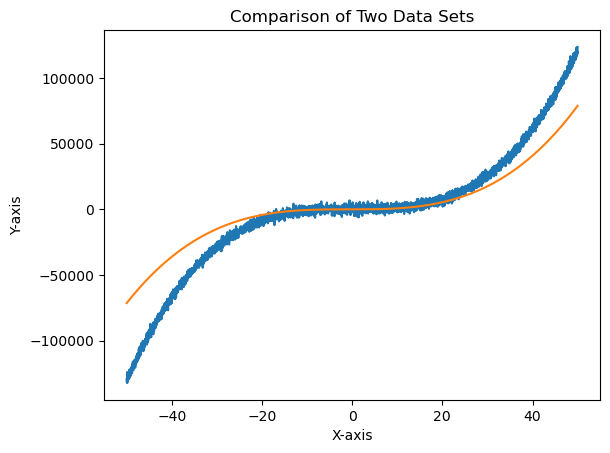

MSE: 376419347.78459847


In [3]:
# Coefficients for the polynomial (a0, a1, a2, a3, a4)
true_coefficients = [250, 2.5, -2, 1]
list = np.linspace(-50, 50, 5000)
estimated_coefficients = [0, 1.2, 1.5, 0.6]

result = generate_polynomial_data(true_coefficients, list, noise_level=2000)
prediction = predict_polynomial(estimated_coefficients, list)

plt.plot(list, result)
plt.plot(list, prediction)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison of Two Data Sets')

plt.show()

print("MSE:", MSE(result, prediction))

In [4]:
# Get two tensors

a = np.array([1, 2, 3, 4, -7])
b = np.array([1, 2, 3, 4, 5])

inputs_tensor = torch.tensor(a, dtype=torch.float32)
true_params_tensor = torch.tensor(b, dtype=torch.float32)


print("Parameter Loss:", compute_parameter_loss(inputs_tensor, true_params_tensor))

Parameter Loss: tensor(-2.4000)


In [5]:
print(np.random.randn(4))

[ 0.12937001 -0.06193608 -1.01617402  0.39952135]


<h2>Generating simulated data<h2>

In [6]:
from data.Data_simulation import DataLoader

In [7]:
# Load the file into a pandas DataFrame
df = pd.read_csv('data/all_data_003.csv')

# Usage example:
data_from_first_row = DataLoader(0, df)

# Output the data extracted from the first row to verify the DataLoader function
print(data_from_first_row)

{'rtim_list': [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85], 'pl_list': [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129], 'bl_list': [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998], 'tac_list': [0.125549, 4.5012, 13.7206, 9.70757, 9.24363, 8.84905, 8.37535, 7.8264, 7.84643, 8.74946, 8.4736, 8.5893, 9.00677, 8.93431, 8.7004, 8.79878, 8.63712, 8.86024, 8.56235, 8.77035, 8.93855, 8.96577], 'gt_parameters_list': [0.13, 0.014, 0.025, 0.05]}


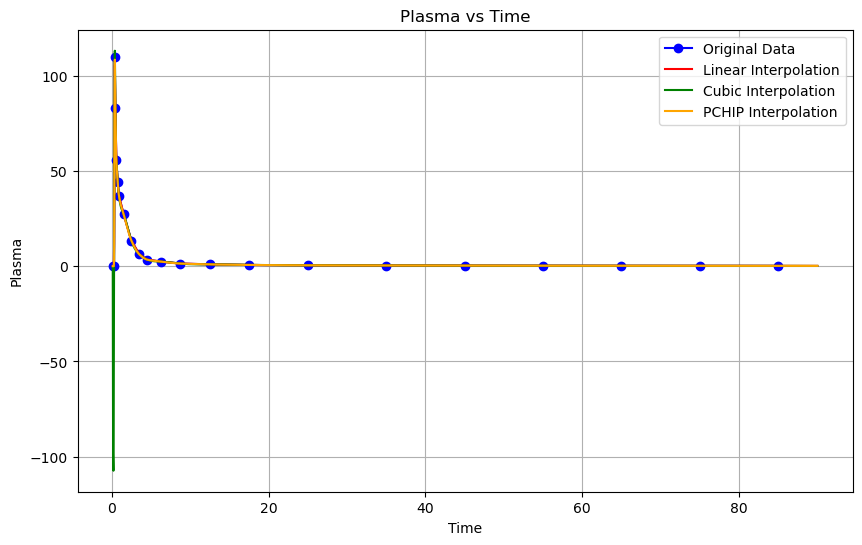

In [8]:
from data.Data_simulation import equidistant_interpolation, plot_interpolations

num_equidistant_points = 2048
new_rtim, linear_pl, cubic_pl, pchip_pl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['pl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['pl_list'], 
                    new_rtim, linear_pl, cubic_pl, pchip_pl, 'Plasma')

In [9]:
# conver pchip_pl to list
pchip_pl_list = pchip_pl.tolist()

print("Plasma pchip", pchip_pl_list)
print("Plasma pchip length", len(pchip_pl_list))
# print("New time", new_rtim)

Plasma pchip [0.05901, 0.056637675603587824, 0.05547719305326996, 0.05509513570762799, 3.592434735456152, 76.66566845125945, 108.62803110406004, 92.5573429263923, 78.29933675629024, 67.06107825999348, 58.23876098298494, 53.30780720033635, 49.94361870493774, 47.33189895076981, 45.01827907182818, 42.66644589125604, 40.42639914056479, 38.48481140381643, 37.02306282096053, 35.93809850568003, 34.96435713961824, 34.088361050727435, 33.29689371474379, 32.576738607403485, 31.914679204442663, 31.29749898159751, 30.711981414604193, 30.14490997919887, 29.58306815111772, 29.013239406096897, 28.422207219872586, 27.79675506818094, 27.13438050161109, 26.461860587907896, 25.783013193747067, 25.099596898012848, 24.413370279589483, 23.726091917361206, 23.039520390212257, 22.35541427702689, 21.67553215668934, 21.001632608083842, 20.335474210094638, 19.67881554160597, 19.033415181502082, 18.401031708667215, 17.783423701985605, 17.182349740341504, 16.599568402619134, 16.036838267702752, 15.495917914476596,

<h3> IRF <h3>

In [10]:
from data.Data_simulation import IRF

IRF_values = IRF(data_from_first_row['gt_parameters_list'], new_rtim)

print("Parameters:", data_from_first_row['gt_parameters_list'])
print(IRF_values)

Parameters: [0.13, 0.014, 0.025, 0.05]
[0.12977305363123387, 0.12969360187710305, 0.12961428605361935, 0.12953510592822487, 0.12945606126875941, 0.12937715184346008, 0.12929837742096045, 0.12921973777028992, 0.1291412326608731, 0.12906286186252902, 0.12898462514547054, 0.12890652228030372, 0.1288285530380269, 0.12875071719003045, 0.12867301450809565, 0.12859544476439436, 0.12851800773148817, 0.12844070318232775, 0.12836353089025232, 0.12828649062898878, 0.12820958217265122, 0.12813280529574017, 0.12805615977314191, 0.12797964538012796, 0.1279032618923542, 0.12782700908586042, 0.12775088673706955, 0.12767489462278706, 0.1275990325202001, 0.1275233002068773, 0.1274476974607676, 0.1273722240602, 0.12729687978388263, 0.1272216644109023, 0.1271465777207237, 0.12707161949318893, 0.12699678950851664, 0.12692208754730155, 0.12684751339051373, 0.12677306681949801, 0.12669874761597325, 0.12662455556203184, 0.1265504904401389, 0.12647655203313177, 0.12640274012421926, 0.1263290544969812, 0.126255

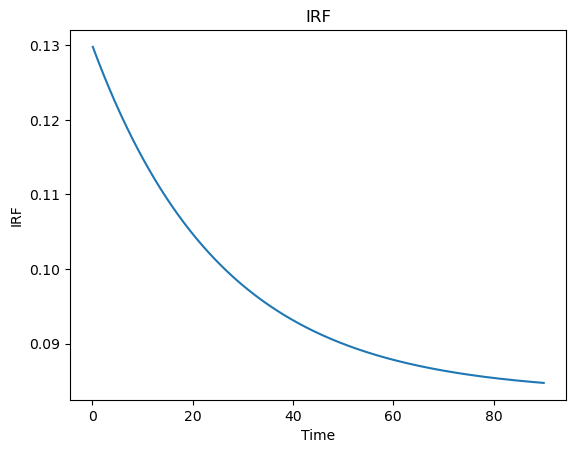

In [11]:
plt.plot(new_rtim, IRF_values)
plt.xlabel('Time')
plt.ylabel('IRF')
plt.title('IRF')
plt.show()

In [12]:
print(data_from_first_row['gt_parameters_list'])

k1 = data_from_first_row['gt_parameters_list'][0]
k2 = data_from_first_row['gt_parameters_list'][1]
k3 = data_from_first_row['gt_parameters_list'][2]
k4 = 0
print((k2 + k3 + k4))
alpha1 = (k2 + k3 + k4) - np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
print(alpha1)
alpha1 /= 2

print(alpha1)

alpha2 = (k2 + k3 + k4) + np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
print(alpha2)
alpha2 /= 2
print(alpha2)

print(np.exp(alpha1*0.1))

print(len(IRF_values))

[0.13, 0.014, 0.025, 0.05]
0.039
0.0
0.0
0.078
0.039
1.0
2048


<h2> C Tissue <h2>

In [13]:
def c_tissue(IRF_values, pchip_pl):
    """
    Calculates the simulated TAC values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated TAC values.
    """
    # Convert lists to PyTorch tensors and add required dimensions for conv1d
    IRF_tensor = torch.tensor(IRF_values).float().unsqueeze(0).unsqueeze(0)
    pchip_pl_tensor = torch.tensor(pchip_pl).float().unsqueeze(0).unsqueeze(0)

    # Perform the convolution using PyTorch's conv1d function
    # The groups argument ensures that each input channel is convolved with its own filter (IRF_tensor)
    result_tensor = F.conv1d(pchip_pl_tensor, IRF_tensor, padding='same', groups=1)

    # Normalize the IRF tensor
    normalized_result_tensor = result_tensor * (90/len(IRF_values)) # Multiply by dt

    # Remove the extra dimensions and convert the tensor back to a list
    simulated_tac_values = normalized_result_tensor.squeeze().tolist()

    return simulated_tac_values

In [14]:
# Normalization methods:

# normalize the IRF tensor
#IRF_tensor = IRF_tensor / torch.norm(IRF_tensor)

# Normalize the convolution result
#num_points = len(IRF_values) 
#normalized_result_tensor = result_tensor / np.sqrt(num_points)

In [15]:
def c_tissue3(IRF_values, pchip_pl):
    # Convert lists to PyTorch tensors
    irf_tensor = torch.tensor(IRF_values).float().view(1, 1, -1)
    pchip_tensor = torch.tensor(pchip_pl).float().view(1, 1, -1)

    # Check if the IRF tensor length is odd, if not, append a zero
    if irf_tensor.shape[-1] % 2 == 0:
        # Append a zero to make the length odd
        irf_tensor = F.pad(irf_tensor, (0, 1))
    
    # Perform the convolution
    result_tensor = F.conv1d(pchip_tensor, irf_tensor, padding='same')

    # Convert the result back to a list
    simulated_tac_values = result_tensor.squeeze().tolist()

    return simulated_tac_values

In [16]:
def c_tissue_torch(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values using PyTorch.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.
    dt (float): The time step increment.

    Returns:
    torch.Tensor: The simulated C_Tissue values.
    """
    # Convert lists to PyTorch tensors and add an extra dimension to match the expected input shape for F.conv1d (Batch, Channel, Length)
    IRF_tensor = torch.tensor(IRF_values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Perform 1D convolution. Note that we need to flip the IRF tensor because PyTorch's conv1d performs cross-correlation.
    # Use padding to control the output size; here, 'same' equivalence is achieved with manual calculation for padding.
    padding_size = (len(IRF_values) - 1) // 2
    simulated_c_tissue_values = F.conv1d(pchip_pl_tensor, IRF_tensor.flip(dims=[-1]), padding=padding_size)

    # Truncate or pad the result to match the desired number of points (if necessary)
    num_points = len(IRF_values)
    if simulated_c_tissue_values.shape[-1] > num_points:
        simulated_c_tissue_values = simulated_c_tissue_values[..., :num_points]
    elif simulated_c_tissue_values.shape[-1] < num_points:
        # This case might not occur in this particular setup, but it's here for completeness
        padding = num_points - simulated_c_tissue_values.shape[-1]
        simulated_c_tissue_values = F.pad(simulated_c_tissue_values, (0, padding))

    # Normalize the convolution result by multiplying by dt
    normalized_result_tensor = simulated_c_tissue_values * dt

    # Remove unnecessary dimensions before returning
    return normalized_result_tensor.squeeze()


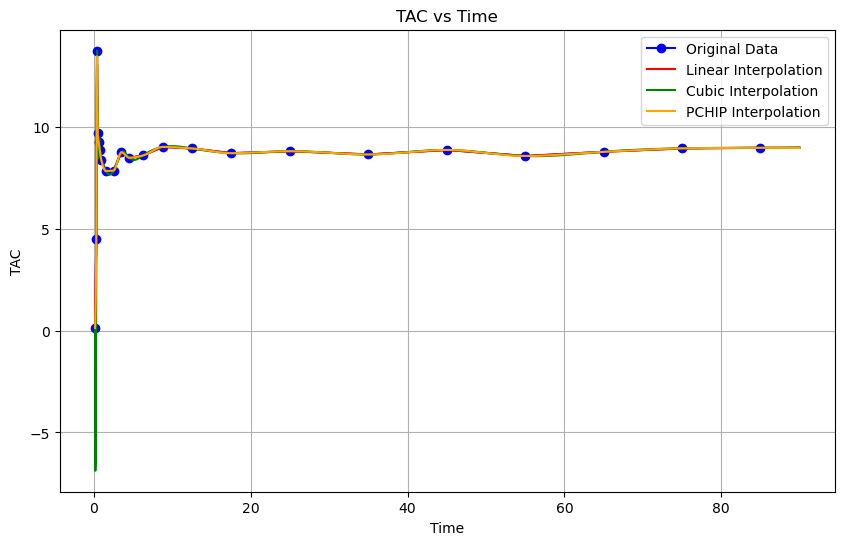

In [17]:
# Get the interpolated tac values
new_rtim, linear_tac, cubic_tac, pchip_tac = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['tac_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['tac_list'], 
                    new_rtim, linear_tac, cubic_tac, pchip_tac, 'TAC')

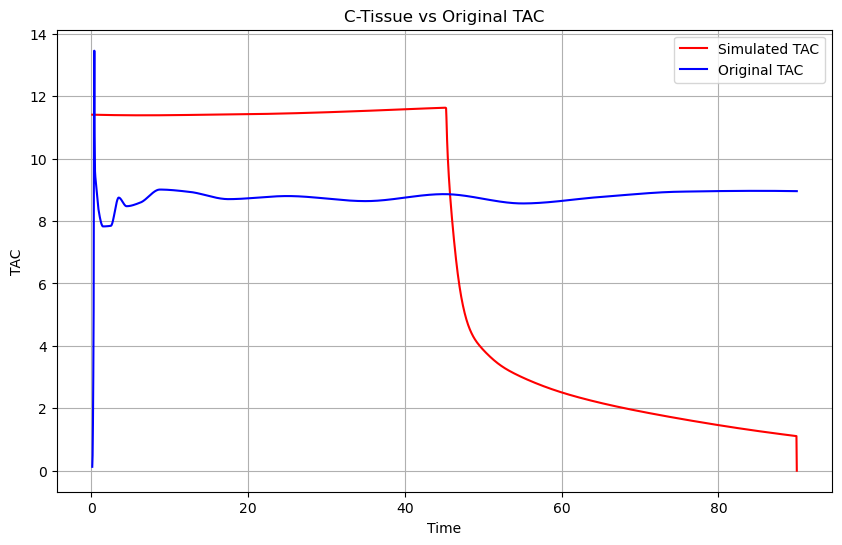

In [18]:
dt = new_rtim[1] - new_rtim[0]
simulated_c_tissue_values = c_tissue_torch(IRF_values, pchip_pl, dt)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()

<h3> Numpy <h3>

In [19]:
def c_tissue4(IRF_values, pchip_pl):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated C_Tissue values.
    """

    # Normalize IRF values
    IRF_values = IRF_values / np.linalg.norm(IRF_values)

    # Compute the convolution of the two lists
    simulated_c_tissue_values = np.convolve(IRF_values, pchip_pl, mode='same')

    return simulated_c_tissue_values.tolist()

In [20]:
simulated_c_tissue_values = c_tissue4(IRF_values, pchip_pl)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))


pl_chip: 2048
IRF: 2048
[59.222278097263015, 59.22088299610817, 59.21949699897091, 59.21812012552697, 59.21675239511846, 59.21539382675415, 59.21404443910959, 59.212704250527416, 59.21137327901738, 59.21005154225672, 59.20873905759023, 59.20743584203044, 59.206141912257905, 59.20485728462131, 59.20358197513769, 59.20231599949263, 59.20105937304044, 59.19981211080429, 59.19857422747656, 59.197345737418786, 59.19612665466211, 59.194916992907245, 59.193716765524826, 59.19252598555545, 59.191344665710005, 59.19017281836973, 59.189010455586555, 59.18785758908308, 59.186714230252925, 59.18558039016087, 59.184456079543, 59.183341308806945, 59.182236088032, 59.181140426969414, 59.18005433504247, 59.17897782134662, 59.17791089464989, 59.176853563392875, 59.17580583568891, 59.17476771932437, 59.17373922175876, 59.172720350124926, 59.171711111229314, 59.17071151155194, 59.1697215572468, 59.168741254141906, 59.16777060773957, 59.16680962321643, 59.165858305423825, 59.1649166588878, 59.163984687809

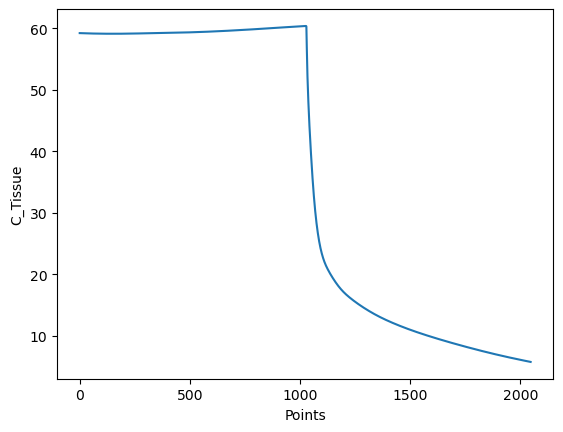

In [21]:
# Plot c_tissue4 values

plt.plot(simulated_c_tissue_values)
plt.xlabel('Points')
plt.ylabel('C_Tissue')
plt.show()

<h3> Scipy <h3>

In [22]:
import scipy.signal

def c_tissue5(IRF_values, pchip_pl, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.
    dt (float): The time step increment.

    Returns:
    list: The simulated C_Tissue values.
    """
    num_points = len(IRF_values) 

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='full')[:num_points]

    # Normalize the convolution result
    normalized_c_tissue = simulated_c_tissue_values * dt # Multiply by dt

    return normalized_c_tissue


In [23]:
dt = new_rtim[1] - new_rtim[0]
simulated_c_tissue_values = c_tissue5(IRF_values, pchip_pl, dt)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

#print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))

pl_chip: 2048
IRF: 2048
2048


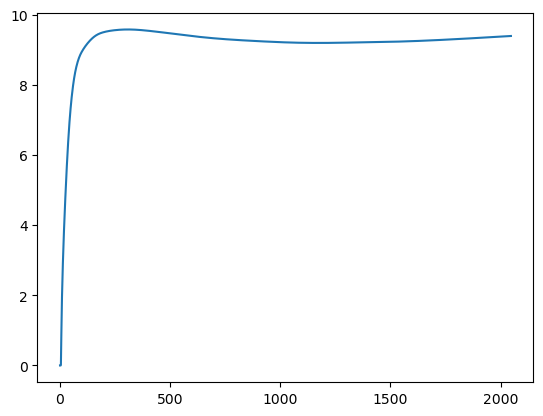

In [24]:
#Divide simulated tac values by constant
simulated_c_tissue_values = [x / 1.238 for x in simulated_c_tissue_values]

plt.plot(simulated_c_tissue_values)
plt.show()

<h2>Simulated TAC <h2>

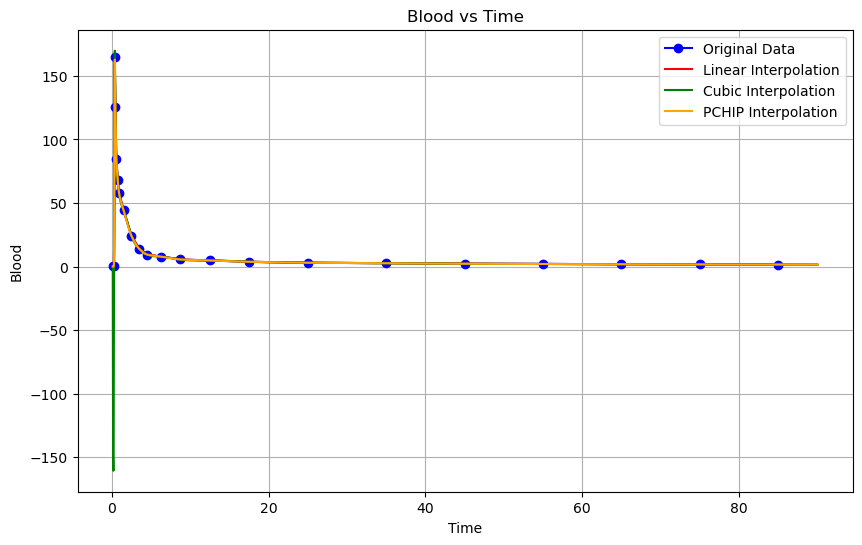

In [25]:
# Get the interpolated blood values
new_rtim, linear_bl, cubic_bl, pchip_bl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['bl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['bl_list'], 
                    new_rtim, linear_bl, cubic_bl, pchip_bl, 'Blood')

In [26]:
print("Blood values:", len(pchip_bl))
print("C_tissue", len(simulated_c_tissue_values))
print("vb:", data_from_first_row['gt_parameters_list'][3])

Blood values: 2048
C_tissue 2048
vb: 0.05


In [27]:
def simulated_tac(c_tissue, gt_parameters_list, bl_list):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values.

    Parameters:
    c_tissue (list): The C_Tissue values.
    gt_parameters_list (list): The ground truth parameters.
    bl_list (list): Blood concentration values.

    Returns:
    list: The simulated TAC values.
    """
    simulated_tac_values = []
    vb = gt_parameters_list[3]

    for i in range(len(c_tissue)):
        value = c_tissue[i] * (1-vb) + vb * bl_list[i]
        simulated_tac_values.append(value)
    
    return simulated_tac_values
    

Simulated TAC: [0.004626508586757685, 0.004704466372294073, 0.00486379403755677, 0.005076927577935564, 0.2856487938297053, 6.092343529600901, 8.962547324883783, 8.187841394126309, 7.478256259956737, 6.934576511753877, 6.532785905104373, 6.40539804941772, 6.378979826972566, 6.396704339697299, 6.42802627310288, 6.449515910504786, 6.471483376330727, 6.505643315492062, 6.56407707272232, 6.6414647507317595, 6.722108079109155, 6.805527021691959, 6.8911991675938085, 6.978544088959762, 7.066923376739675, 7.155640676400353, 7.243941723576631, 7.331014379661445, 7.415988667335009, 7.49793680603322, 7.575873247355373, 7.648754710411301, 7.716234849203691, 7.780032660618334, 7.84038222023003, 7.897389761149993, 7.951169214429691, 8.001842204338057, 8.04953804364681, 8.09439372892383, 8.136553935834579, 8.176171014451588, 8.213404984571937, 8.248423531042755, 8.281401999094744, 8.312523389683632, 8.341978354839657, 8.36996519302496, 8.396689844498958, 8.422365886691603, 8.447214529584606, 8.4714646

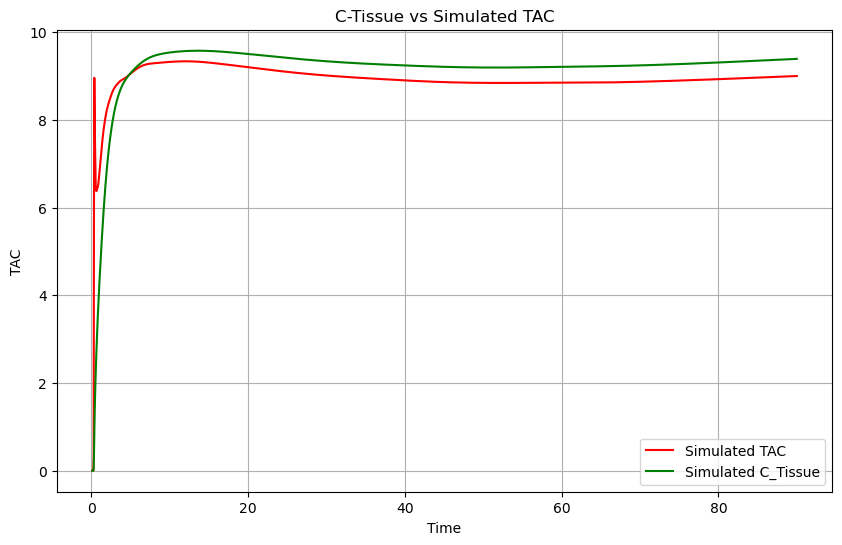

In [28]:
simulated_tac_values = simulated_tac(simulated_c_tissue_values, data_from_first_row['gt_parameters_list'], pchip_bl)
print("Simulated TAC:", simulated_tac_values)
print("CTissue:" , simulated_c_tissue_values)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated C_Tissue', color='green')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Simulated TAC')
plt.legend()
plt.grid(True)
plt.show()

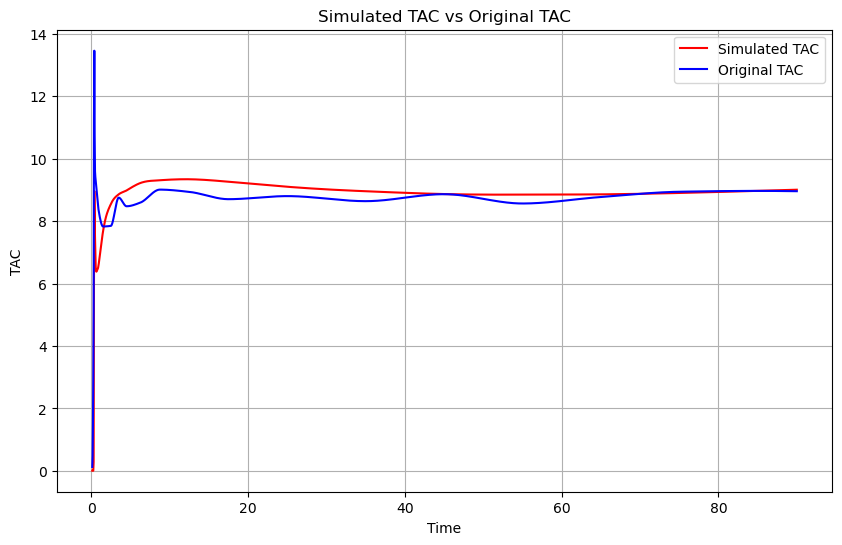

In [29]:
# Plot the simulated TAC values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, pchip_tac, label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Simulated TAC vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()

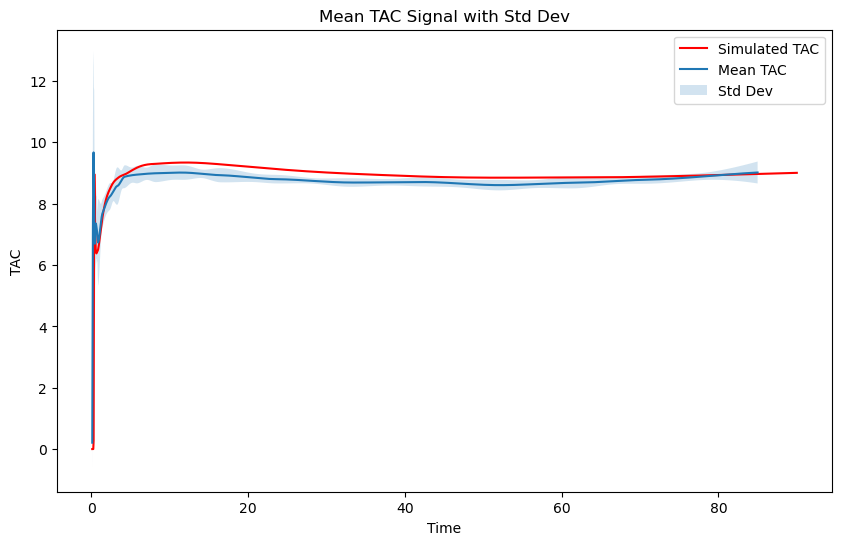

In [30]:
# Initialize lists to store interpolated TAC signals
all_linear_tac = []

# Iterate over the first 25 rows of the DataFrame
for i in range(25):
    data_from_row = DataLoader(i, df)  # Adjust this if DataLoader usage is different
    # Apply equidistant interpolation to each row
    _, _, _, pchip_tac = equidistant_interpolation(data_from_row['rtim_list'],
                                                    data_from_row['tac_list'],
                                                    num_equidistant_points)
    # Append the interpolated signal to the list
    all_linear_tac.append(pchip_tac)

# Convert the list of arrays into a 2D numpy array for easier manipulation
all_linear_tac = np.array(all_linear_tac)

# Calculate the mean and standard deviation across the 25 signals
mean_tac = np.mean(all_linear_tac, axis=0)
std_tac = np.std(all_linear_tac, axis=0)

# Create the time points for plotting, assuming equidistant spacing
time_points = np.linspace(min(data_from_row['rtim_list']), max(data_from_row['rtim_list']), num_equidistant_points)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(time_points, mean_tac, label='Mean TAC')
plt.fill_between(time_points, mean_tac-std_tac, mean_tac+std_tac, alpha=0.2, label='Std Dev')
plt.title('Mean TAC Signal with Std Dev')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.legend()
plt.show()


<h2> Noise <h2>

In [67]:
def adding_noise_simple(simulated_tac_values, new_rtim, original_time):
    """
    Adds normal noise to the simulated TAC values.

    Parameters:
    simulated_tac_values (list): The simulated TAC values.
    new_rtim (list): The new resampled time points.
    original_time (list): The original time points.

    Returns:
    list: The noisy TAC values.
    list: The added noise.
    float: The COVi value.
    """
    # Convert inputs to numpy arrays for efficient computation
    simulated_tac_values = np.array(simulated_tac_values)
    new_rtim = np.array(new_rtim)
    original_time = np.array(original_time)

    # Get the indices of the closest points in original time to the new resampled time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in original_time]
    
    # Select the corresponding TAC values based on the closest indices
    tac_values_at_closest_indices = simulated_tac_values[closest_indices]

    # Get the last three TAC values
    last_three_tac = tac_values_at_closest_indices[-3:]

    # Calculate the standard deviation using the last three TAC values
    std_dev = np.std(last_three_tac)

    # Calculate the mean of the last three TAC values
    mean = np.mean(last_three_tac)

    # Calculate COVi:
    COVi = std_dev / mean

    # Add Gaussian noise
    noise = np.random.normal(0, std_dev, len(simulated_tac_values))
    # noise = np.random.normal(0, 0.02 * mean, len(simulated_tac_values))
    noisy_tac = simulated_tac_values + noise

    return noisy_tac, noise, COVi

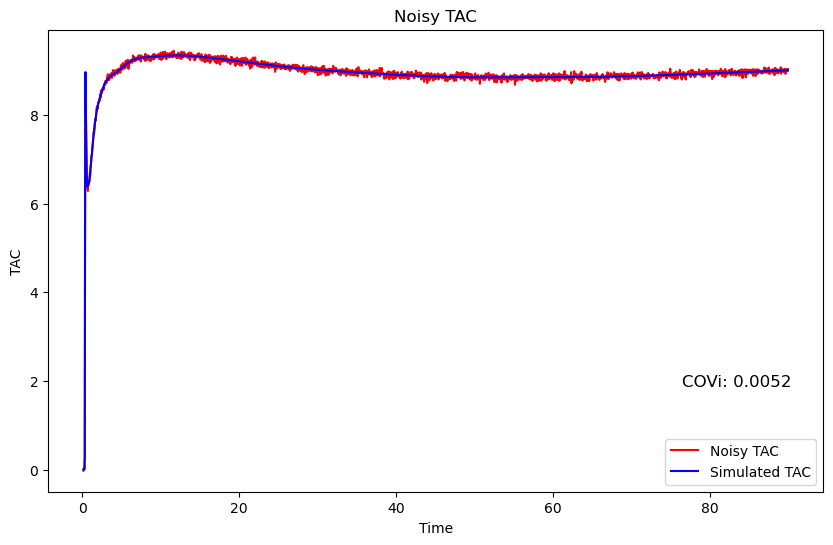

In [75]:
noisy_tac, noise, COVi = adding_noise_simple(simulated_tac_values, new_rtim, data_from_row['rtim_list'])

# Plot the noisy TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, noisy_tac, label='Noisy TAC', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC')
# Add the COVi value as text on the plot
# You can adjust the x and y values to place the text appropriately on your plot
plt.text(x=max(new_rtim) * 0.85, y=max(noisy_tac) * 0.2, s=f'COVi: {COVi:.4f}', fontsize=12, color='black')
plt.legend()
plt.show()

In [44]:
def adding_noise_advanced(simulated_tac_values, new_rtim, type):
    """
    Adds noise to the simulated TAC values in a more advanced way. The variance of the noise is calculated for each tac window.

    Parameters:
    simulated_tac_values (list): The simulated TAC values.
    new_rtim (list): The new time points.
    type (str): The type of noise to add. Either 'Poisson' or 'Normal'.

    Returns:
    list: The simulated TAC values with added noise.
    """
    # List of original time points
    times = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85]
    lengths = [0.166667, 0.083333, 0.083333, 0.125, 0.166667, 0.166667, 0.583333, 1, 1, 1, 1.75, 1.5, 3.75, 5, 7.5, 10, 10, 10, 10, 10, 10, 10]

    # Find new_rtim values that are closest to the original time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in times]

    # Calculate the mean and standard deviation of the TAC values in each window
    mean_values = []
    std_dev_values = []
    for i in range(len(times)):
        if i == len(times) - 1:
            # Last interval
            interval_tac = simulated_tac_values[closest_indices[i]:]
        else:
            interval_tac = simulated_tac_values[closest_indices[i]:closest_indices[i+1]]
        mean_values.append(np.mean(interval_tac))
        std_dev_values.append(np.std(interval_tac))
    
    # Add noise to each window
    noisy_tac = []
    noise = []
    for i in range(len(times)):
        # Determine start index
        start_index = closest_indices[i]
        
        # Determine end index: If it's the last element, slice to the end of the array. Otherwise, use the next closest index.
        if i == len(times) - 1:
            end_index = None 
        else:
            end_index = closest_indices[i + 1]
        
        # Slicing tac_window and corresponding new_rtim values
        tac_window = simulated_tac_values[start_index:end_index]
        rtim_window = new_rtim[start_index:end_index]
        
        # Calculate simulated tac integral for the window
        dcfi = np.trapz(tac_window, rtim_window) / lengths[i]

        # Calculate the local variance
        local_variance = dcfi**2 / (lengths[i]**2)
        
        # Generate the noise
        if type == 'Poisson':
            local_noise = np.random.poisson(0.05 * mean_values[i], size=len(tac_window))
            #local_noise = np.random.poisson(np.sqrt(local_variance), size=len(tac_window))
        else:
            local_noise = np.random.normal(0, 0.05 * mean_values[i], size= len(tac_window))
            #local_noise = np.random.normal(0, np.sqrt(local_variance), size=len(tac_window))
        
        noise += local_noise.tolist()

        print("COVi:", std_dev_values[i]/mean_values[i])
        
    simulated_tac_values = np.array(simulated_tac_values)
    noise = np.array(noise)
    noisy_tac = simulated_tac_values + noise
        
    return noisy_tac, noise

COVi: 0.03575479743032557
COVi: 0.9104267363946716
COVi: 0.0451713336327335
COVi: 0.03772192162459483
COVi: 0.009485362856554587
COVi: 0.0044394366523525
COVi: 0.04534196383211171
COVi: 0.03159192213849507
COVi: 0.010357018944164683
COVi: 0.00372139483621709
COVi: 0.007672970631988209
COVi: 0.002548469065865369
COVi: 0.0011070921934292273
COVi: 0.0025753189303808033
COVi: 0.005152728729315633
COVi: 0.004564352621307511
COVi: 0.0029956154609898826
COVi: 0.0006083826115341257
COVi: 0.00018687139365378277
COVi: 0.0014689181993870857
COVi: 0.002199446002971513
COVi: 0.0011877601265886256
COVi: 0.03575479743032557
COVi: 0.9104267363946716
COVi: 0.0451713336327335
COVi: 0.03772192162459483
COVi: 0.009485362856554587
COVi: 0.0044394366523525
COVi: 0.04534196383211171
COVi: 0.03159192213849507
COVi: 0.010357018944164683
COVi: 0.00372139483621709
COVi: 0.007672970631988209
COVi: 0.002548469065865369
COVi: 0.0011070921934292273
COVi: 0.0025753189303808033
COVi: 0.005152728729315633
COVi: 0.00456

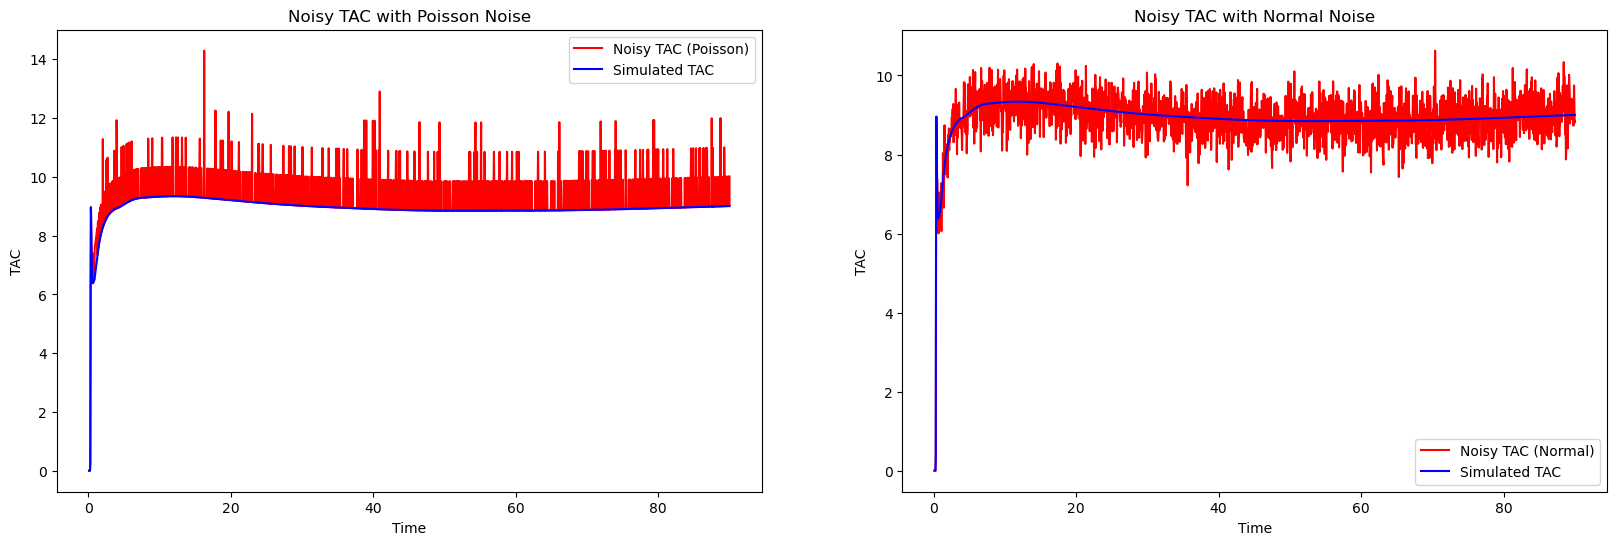

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the adding_noise_advanced function exists and can handle 'Poisson' and 'Normal' as noise types
# First, generate noisy TAC values with Poisson noise
noisy_tac_poisson, noise_poisson = adding_noise_advanced(simulated_tac_values, new_rtim, 'Poisson')

# Then, generate noisy TAC values with Normal noise
noisy_tac_normal, noise_normal = adding_noise_advanced(simulated_tac_values, new_rtim, 'Normal')

# Plot both noisy TAC values side by side
plt.figure(figsize=(20, 6))  # Adjust the figure size as needed

# Plot for Poisson noise
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(new_rtim, noisy_tac_poisson, label='Noisy TAC (Poisson)', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC with Poisson Noise')
plt.legend()

# Plot for Normal noise
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(new_rtim, noisy_tac_normal, label='Noisy TAC (Normal)', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC with Normal Noise')
plt.legend()

plt.show()


COVi: 0.03575479743032557
COVi: 0.9104267363946716
COVi: 0.0451713336327335
COVi: 0.03772192162459483
COVi: 0.009485362856554587
COVi: 0.0044394366523525
COVi: 0.04534196383211171
COVi: 0.03159192213849507
COVi: 0.010357018944164683
COVi: 0.00372139483621709
COVi: 0.007672970631988209
COVi: 0.002548469065865369
COVi: 0.0011070921934292273
COVi: 0.0025753189303808033
COVi: 0.005152728729315633
COVi: 0.004564352621307511
COVi: 0.0029956154609898826
COVi: 0.0006083826115341257
COVi: 0.00018687139365378277
COVi: 0.0014689181993870857
COVi: 0.002199446002971513
COVi: 0.0011877601265886256
COVi: 0.03575479743032557
COVi: 0.9104267363946716
COVi: 0.0451713336327335
COVi: 0.03772192162459483
COVi: 0.009485362856554587
COVi: 0.0044394366523525
COVi: 0.04534196383211171
COVi: 0.03159192213849507
COVi: 0.010357018944164683
COVi: 0.00372139483621709
COVi: 0.007672970631988209
COVi: 0.002548469065865369
COVi: 0.0011070921934292273
COVi: 0.0025753189303808033
COVi: 0.005152728729315633
COVi: 0.00456

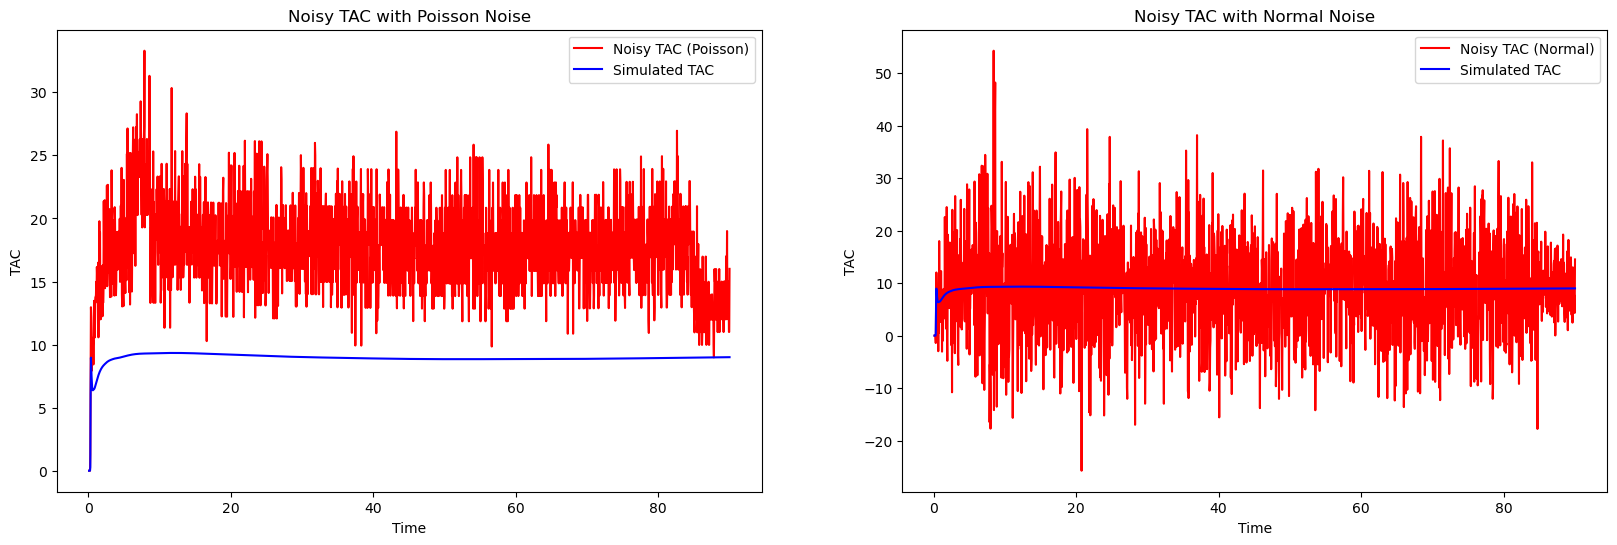

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the adding_noise_advanced function exists and can handle 'Poisson' and 'Normal' as noise types
# First, generate noisy TAC values with Poisson noise
noisy_tac_poisson, noise_poisson = adding_noise_advanced(simulated_tac_values, new_rtim, 'Poisson')

# Then, generate noisy TAC values with Normal noise
noisy_tac_normal, noise_normal = adding_noise_advanced(simulated_tac_values, new_rtim, 'Normal')

# Plot both noisy TAC values side by side
plt.figure(figsize=(20, 6))  # Adjust the figure size as needed

# Plot for Poisson noise
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(new_rtim, noisy_tac_poisson, label='Noisy TAC (Poisson)', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC with Poisson Noise')
plt.legend()

# Plot for Normal noise
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(new_rtim, noisy_tac_normal, label='Noisy TAC (Normal)', color='red')
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('Noisy TAC with Normal Noise')
plt.legend()

plt.show()
